This notebook simulates the effect of spill-back in CMOS detectors. Spill-back occurs during readout of a CMOS detector, when a large enough amount of charge has accumulated on the floating diffusion mode such that the floating diffusion node and transfer gate are equipotential. Some excess charge may then sit on the transfer gate and may "spill back" over to the pinned photodiode when the transfer gate is reset. This leads to image lag and a nonlinear photon transfer curve.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from cosmos_helper_funcs import get_stacks, label_plot, cosmos_gain_dict, get_mean_images
from defect_pixel_funcs import *
from scipy.optimize import curve_fit

In [2]:
def spill_back(electrons, spill_cut_on, spill_back_frac):
    if electrons > spill_cut_on:
        return electrons - (electrons - spill_cut_on) * spill_back_frac
    else:
        return electrons

Simulate the effects of spill-back on a linearity curve and on a photon transfer curve.

In [3]:
num_levels = 100
# Number of photons striking the sensor
illumination_levels = np.linspace(0, 1000, num_levels)
# Quantum efficiency of the sensor
qe = 1
# Gain, in ADU/electron
gain = 3
# Read noise, in electrons
read_noise = 10
# Onset of the spill-back regime, in electrons
spill_back_onset = 300
# Fraction of charge above the spill-back threshold that is spilled back into the pixel
spill_back_frac = 0.1
# Number of readings at each illumination level
num_readings = 10000
# Full well capacity, in ADU
full_well = 2048
num_photoelectrons = np.random.poisson(illumination_levels, np.array([num_readings, num_levels])).transpose()
num_photoelectrons = np.vectorize(spill_back)(num_photoelectrons, spill_back_onset, spill_back_frac)
measured_signals = (num_photoelectrons + np.random.normal(0, read_noise, num_readings)) * gain
measured_signals = np.clip(measured_signals, 0, full_well)
signal_means = np.mean(measured_signals, axis=1)
signal_vars = np.var(measured_signals, axis=1)

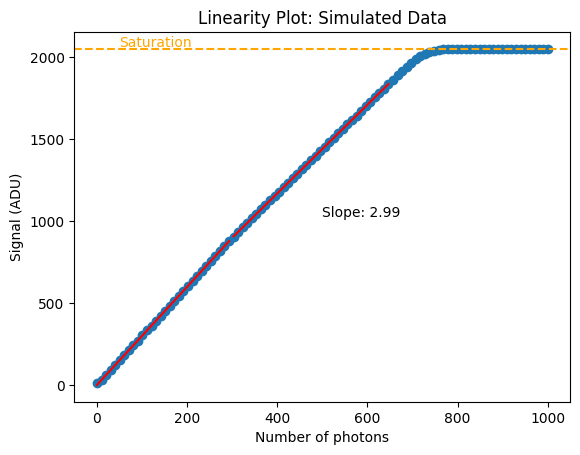

In [4]:
%matplotlib inline
plt.plot(illumination_levels, signal_means, 'o')
# Fit points below spill-back threshold
popt1, pcov1 = curve_fit(lambda x, a, b: a * x + b, illumination_levels[illumination_levels < spill_back_onset], signal_means[illumination_levels < spill_back_onset])
plt.plot(illumination_levels[illumination_levels < spill_back_onset], popt1[0] * illumination_levels[illumination_levels < spill_back_onset] + popt1[1], 'r')
plt.text(0.5, 0.5, 'Slope: {:.2f}'.format(popt1[0]), transform=plt.gca().transAxes)
# plt.text(0.5, 0.5, 'Slope of first part: {:.2f}'.format(popt1[0]), transform=plt.gca().transAxes)
second_part_range = (illumination_levels > spill_back_onset) & (signal_means < 0.9 * full_well)
popt2, pcov2 = curve_fit(lambda x, a, b: a * x + b, illumination_levels[second_part_range], signal_means[second_part_range])
plt.plot(illumination_levels[second_part_range], popt2[0] * illumination_levels[second_part_range] + popt2[1], 'r')
# plt.text(0.5, 0.4, 'Slope of second part: {:.2f}'.format(popt2[0]), transform=plt.gca().transAxes)
# plt.text(0.5, 0.3, 'Ratio of slopes: {:.2f}'.format(popt2[0] / popt1[0]), transform=plt.gca().transAxes)
# plt.text(0.5, 0.2, 'Actual Spill-Back Fraction: {:.2f}'.format(spill_back_frac), transform=plt.gca().transAxes)
plt.xlabel('Number of photons')
plt.ylabel('Signal (ADU)')
plt.title('Linearity Plot: Simulated Data')
# plt.axhline(spill_back_onset * gain, color='g', linestyle='--')
# plt.text(50, spill_back_onset * gain + 50, 'Spill-back onset', color='g')
plt.axhline(full_well, color='orange', linestyle='--')
plt.text(50, full_well + 10, 'Saturation', color='orange')
plt.show()

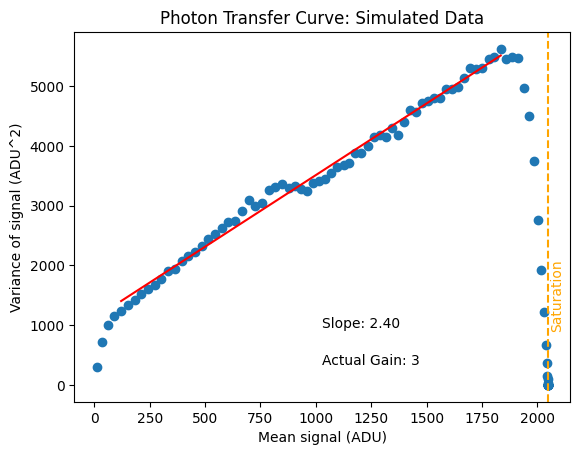

In [5]:
%matplotlib inline
fit_points_x = signal_means[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * full_well)]
fit_points_y = signal_vars[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * full_well)]
# fit_points_x = signal_means[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * spill_back_onset * gain)]
# fit_points_y = signal_vars[(signal_means > 0.05 * full_well) & (signal_means < 0.9 * spill_back_onset * gain)]
popt, pcov = curve_fit(lambda x, a, b: a*x + b, fit_points_x, fit_points_y)
fit_points_x_2 = signal_means[(signal_means > 1.05 * spill_back_onset * gain) & (signal_means < 0.9 * full_well)]
fit_points_y_2 = signal_vars[(signal_means > 1.05 * spill_back_onset * gain) & (signal_means < 0.9 * full_well)]
popt2, pcov2 = curve_fit(lambda x, a, b: a*x + b, fit_points_x_2, fit_points_y_2)
plt.plot(signal_means, signal_vars, 'o')
plt.xlabel('Mean signal (ADU)')
plt.ylabel('Variance of signal (ADU^2)')
plt.plot(fit_points_x, popt[0] * fit_points_x + popt[1], 'r')
plt.text(0.5, 0.2, f'Slope: {popt[0]:.2f}', transform=plt.gca().transAxes)
# plt.plot(fit_points_x_2, popt2[0] * fit_points_x_2 + popt2[1], 'r')
# plt.text(0.5, 0.3, f'Slope of First Part: {popt[0]:.2f}', transform=plt.gca().transAxes)
# plt.text(0.5, 0.2, f'Slope of Second Part: {popt2[0]:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.1, f'Actual Gain: {gain}', transform=plt.gca().transAxes)
plt.title('Photon Transfer Curve: Simulated Data')
# plt.axvline(spill_back_onset * gain, color='g', linestyle='--')
# plt.text(spill_back_onset * gain + 10, 1500, 'Spill-back onset', rotation=90, verticalalignment='center', color='g')
plt.axvline(full_well, color='orange', linestyle='--')
plt.text(full_well + 10, 1500, 'Saturation', rotation=90, verticalalignment='center', color='orange')
plt.show()

Look at COSMOS data

In [32]:
gray_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Spill-Back/HS_HG_RS/Shutter Open'
gray_stacks = get_stacks(gray_folder, num_imgs=3)
dark_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Spill-Back/HS_HG_RS/Shutter Closed'
dark_stacks = get_stacks(dark_folder)
dark_mean_imgs = get_mean_images(dark_stacks)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Spill-Back/HS_HG_RS/Shutter Open/HighSHighG_RS_raw_2s_SO 2024 May 02 11_53_56.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Spill-Back/HS_HG_RS/Shutter Open/HighSHighG_RS_raw_3600ms_SO 2024 May 02 14_00_25.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Spill-Back/HS_HG_RS/Shutter Open/HighSHighG_RS_raw_1600ms_SO 2024 May 02 13_26_39.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Spill-Back/HS_HG_RS/Shutter Open/HighSHighG_RS_raw_200ms_SO 2024 May 02 13_24_17.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain 

In [34]:
exp_times = np.zeros(len(gray_stacks))
mean_list = np.zeros(len(gray_stacks))
var_list = np.zeros(len(gray_stacks))
for i, stack in enumerate(gray_stacks):
    exp_time_ms = float(stack['exposure_ms'])
    exp_time_str = str(int(1000 * exp_time_ms))
    img_1 = stack['imagestack'][1]
    img_2 = stack['imagestack'][2]
    dark_img_str = 'HS_HG_RS_' + exp_time_str + 'us'
    dark_img = dark_mean_imgs[dark_img_str]
    temp_var = np.var(img_1 - img_2) / 2
    clean_img = (img_1 + img_2) / 2 - dark_img
    img_mean = np.nanmean(clean_img)
    exp_times[i] = exp_time_ms
    mean_list[i] = img_mean
    var_list[i] = temp_var

# Sort the lists by exposure time
sort_order = np.argsort(exp_times)
exp_times = exp_times[sort_order]
mean_list = mean_list[sort_order]
var_list = var_list[sort_order]

In [40]:
# A function to find where there is a "kink" in a plot of x vs y.
# This kink should occur at the spill-back threshold.
def find_spill_back_threshold(x, y):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    # If no negative numbers of sufficient absolute value, return the last index
    if np.min(d2y) > -1e-5:
        kink_idx = None
        print('No spill-back identified')
    else:
        kink_idx = np.argmin(d2y)
        print('Spill-back threshold: ', format(int(y[kink_idx]), '3d'), ' ADU')
    return kink_idx

bits = 18
low_lim = np.rint(np.max(mean_list) * 0.05)
high_lim = np.rint(np.max(mean_list) * 0.9)
fit_exp_times = exp_times[(mean_list > low_lim) & (mean_list < high_lim)]
fit_mean_list = mean_list[(mean_list > low_lim) & (mean_list < high_lim)]
fit_var_list = var_list[(mean_list > low_lim) & (mean_list < high_lim)]
threshold_idx = find_spill_back_threshold(fit_exp_times, fit_mean_list)
# threshold_idx = None

Spill-back threshold:  7551  ADU


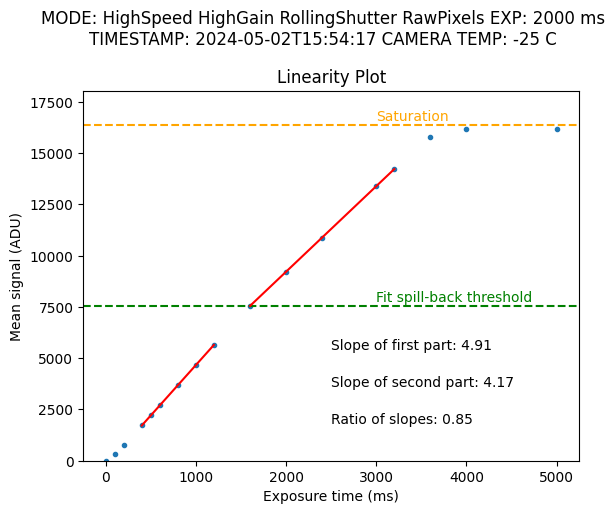

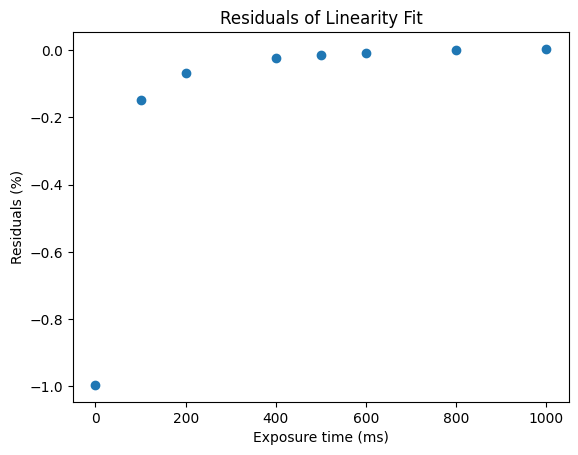

In [49]:
plt.plot(exp_times, mean_list, 'o', markersize=3)
if threshold_idx is not None:
    plt.axhline(fit_mean_list[threshold_idx], color='g', linestyle='--')
    plt.text(3000, fit_mean_list[threshold_idx] + 200, 'Fit spill-back threshold', color='g')
    popt1, pcov1 = curve_fit(lambda x, a, b: a * x + b, fit_exp_times[:threshold_idx], fit_mean_list[:threshold_idx])
    plt.plot(fit_exp_times[:threshold_idx], popt1[0] * fit_exp_times[:threshold_idx] + popt1[1], c='r')
    plt.text(0.5, 0.3, f'Slope of first part: {popt1[0]:.2f}', transform=plt.gca().transAxes)
    popt2, pcov2 = curve_fit(lambda x, a, b: a * x + b, fit_exp_times[threshold_idx:], fit_mean_list[threshold_idx:])
    plt.plot(fit_exp_times[threshold_idx:], popt2[0] * fit_exp_times[threshold_idx:] + popt2[1], c='r')
    plt.text(0.5, 0.2, f'Slope of second part: {popt2[0]:.2f}', transform=plt.gca().transAxes)
    plt.text(0.5, 0.1, f'Ratio of slopes: {popt2[0]/popt1[0]:.2f}', transform=plt.gca().transAxes)
else:
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, fit_exp_times, fit_mean_list)
    plt.plot(fit_exp_times, popt[0] * fit_exp_times + popt[1], c='r')
    plt.text(0.5, 0.3, f'Slope of fit: {popt[0]:.2f}', transform=plt.gca().transAxes)
    plt.text(0.5, 0.2, f'No spill-back identified', transform=plt.gca().transAxes)
bits = 14
plt.axhline(2**bits - 1, color='orange', linestyle='--')
plt.text(3000, 2**bits - 1 + 200, 'Saturation', color='orange')
plt.xlabel('Exposure time (ms)')
plt.ylabel('Mean signal (ADU)')
plt.ylim(0, 2**bits * 1.1)
plt.title('Linearity Plot')
label_plot(gray_stacks[0])
plt.show()
# Plot residuals
if threshold_idx is not None:
    residuals = (mean_list[:8] - popt[0] * exp_times[:8] - popt[1]) / (popt[0] * mean_list[:8] + popt[1])
else:
    residuals = (mean_list - popt[0] * exp_times - popt[1]) / (popt[0] * exp_times + popt[1])
plt.plot(exp_times[:8], residuals, 'o')
plt.xlabel('Exposure time (ms)')
plt.ylabel('Residuals (%)')
plt.title('Residuals of Linearity Fit')
plt.show()

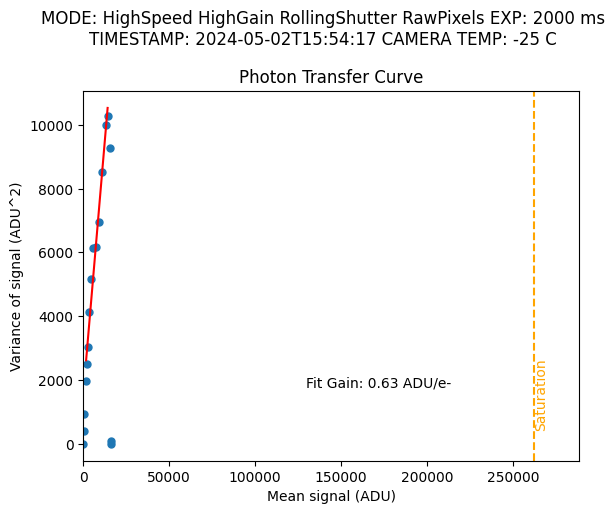

In [37]:
plt.plot(mean_list, var_list, 'o', markersize=5)
label_plot(gray_stacks[0])
if threshold_idx is not None:
    popt3, pcov3 = curve_fit(lambda x, a, b: a * x + b, fit_mean_list[:threshold_idx], fit_var_list[:threshold_idx])
    plt.plot(fit_mean_list[:threshold_idx], popt3[0] * fit_mean_list[:threshold_idx] + popt3[1], c='r')
    plt.axvline(fit_mean_list[threshold_idx], color='g', linestyle='--')
    plt.text(fit_mean_list[threshold_idx] + 200, 500, 'Fit spill-back threshold', color='g', rotation=90)
else:
    popt3, pcov3 = curve_fit(lambda x, a, b: a * x + b, fit_mean_list, fit_var_list)
    plt.plot(fit_mean_list, popt3[0] * fit_mean_list + popt3[1], c='r')
actual_gain = 1 / cosmos_gain_dict['XRgain_HSLGRS']
plt.text(0.45, 0.2, f'Fit Gain: {popt3[0]:.2f} ADU/e-', transform=plt.gca().transAxes)
# plt.text(0.45, 0.1, f'Gain Found with X-rays: {actual_gain:.2f} ADU/e-', transform=plt.gca().transAxes)
plt.axvline(2**bits - 1, color='orange', linestyle='--')
plt.text(2**bits - 1 + 200, 500, 'Saturation', color='orange', rotation=90)
plt.xlabel('Mean signal (ADU)')
plt.ylabel('Variance of signal (ADU^2)')
plt.xlim(0, 2**bits * 1.1)
plt.title('Photon Transfer Curve')
plt.show()

In [ ]:
np.sqrt(np.mean((dark_stacks[5]['imagestack'][2] - dark_stacks[5]['imagestack'][1]) ** 2) / 2) * 0.4

1.2314996627486918